# Python notebook to reproduce _Figure 3_

In [35]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import anndata
import numpy as np
import json

sys.path.append(os.path.join(sys.path[0], '../'))
import plot_settings
import plot_utils
from figures.additional_utils import aging_utils, velocity_plot_utils

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
fig_dir = 'figure_3/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [23]:
data, organs, gen_ts = aging_utils.load_imputed_early_development_data('Mouse', -5, 13)

In [24]:
N, T, M = data['Brain'].shape

In [25]:
organ_listing = [org for org in organs for _ in range(N) for _ in range(T)]
time_listing = []
for org in organs:
    ts = []
    for n in range(N):
        ts.append(np.arange(-5, 13, 0.1))
    time_listing.append(np.stack(ts, axis=0))
time_listing = np.stack(time_listing, axis=0)
time_listing = time_listing.reshape(-1)

Processing for 3a,b

In [26]:
from sklearn.manifold import TSNE
# from umap import UMAP as TNSE

tsne_seed = 15

full_data = np.stack([data[org] for org in data], axis=0)  # O x N x T x M
flattened_data = full_data.reshape(-1, M)

tsne_data = TSNE(random_state=tsne_seed).fit_transform(flattened_data)
shaped_tsne_data = tsne_data.reshape(-1, N, T, 2)

shaped_tsne_velocity = []
for org in range(len(organs)):
    vels = []
    for n in range(N):
        vels.append(np.stack(
            [shaped_tsne_data[org][n][t+1] - shaped_tsne_data[org][n][t-1] if t != T-1 else np.zeros((2))
             for t in range(T)], axis=0))
    shaped_tsne_velocity.append(np.stack(vels, axis=0))
    
shaped_tsne_velocity = np.stack(shaped_tsne_velocity, axis=0)
tsne_velocity = shaped_tsne_velocity.reshape(-1, 2)

def moving_average_results(vel, minT, maxT, granularity, k=None, restrict_to_indices=False):    
    N, Tfull, _ = vel.shape
    smoothed_vel = []
    if k is None:
        k = int(1. / granularity)
    imputed_ts = np.arange(minT, maxT, granularity)
    for t in range(Tfull):
        mint = max(0, t-k)
        maxt = min(Tfull, t+k)
        
        if not restrict_to_indices or abs(imputed_ts[t] - np.round(imputed_ts[t])) < 1e-2:
            avg = np.mean(vel[:, mint:maxt, :], axis=1)  # N x M
            if not restrict_to_indices:
                smoothed_vel.append(avg)
            else:
                cnt = int(1. / granularity)
                smoothed_vel.extend([avg for _ in range(cnt)])
    return np.stack(smoothed_vel, axis=1)  # N x Tfull x M

avg_tsne_velocities = np.mean(shaped_tsne_velocity, axis=1)
avg_tsne_velocities = np.stack([avg_tsne_velocities for _ in range(N)], axis=1)
flat_avg_tsne_velocities = avg_tsne_velocities.reshape(-1, 2)
flat_smoothed_avg_vels = smoothed_avg_vels.reshape(-1, 2)

# Code to reproduce figure 3

Fig. 3a

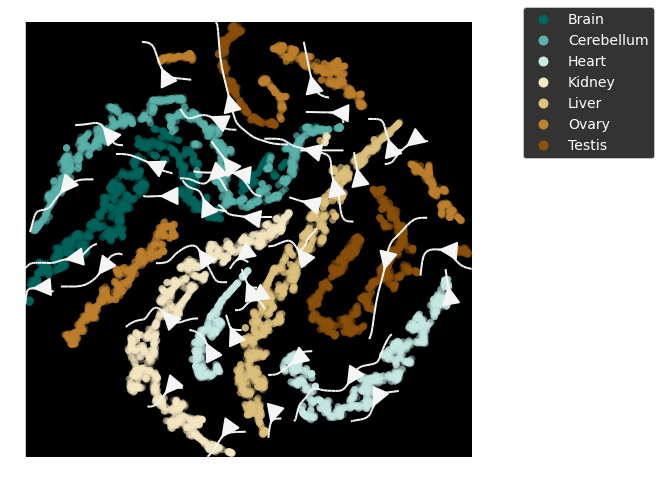

In [28]:
%matplotlib inline

ax = plot_settings.get_double_square_axis()

colors = plot_settings.get_organ_color_palette()
for i, org in enumerate(organs):
    idxs = np.where(np.asarray(organ_listing) == org)
    org_adata = anndata.AnnData(flattened_data[idxs])
    org_adata.obs['organ'] = np.asarray(organ_listing)[idxs]
    org_adata.obs['time'] = time_listing.astype(np.float64)[idxs]
    org_adata.obsm['X_tsne'] = tsne_data[idxs]

    velocity_plot_utils.velocity_embedding_stream(
        org_adata, V=flat_smoothed_avg_vels[idxs], n_neighbors=100, cutoff_perc=5, 
        color=colors[i],  alpha=0.3, density=0.1, smooth=1.0, size=200, linewidth=2, 
        arrowsize=4, ax=ax, arrow_color='whitesmoke', 
        legend_loc='upper right')
    
lp = lambda i: plt.plot([],color=colors[i], ms=10, 
                        mec="none", label=organs[i], ls="", 
                        marker="o")[0]
handles = [lp(i) for i in range(len(organs))]

plot_utils.format_legend(ax, handles, organs)
plot_utils.put_legend_outside_plot(ax)
plot_utils.format_ax(ax)
plt.savefig(fig_dir + 'figure_3a.pdf')

Fig. 3b

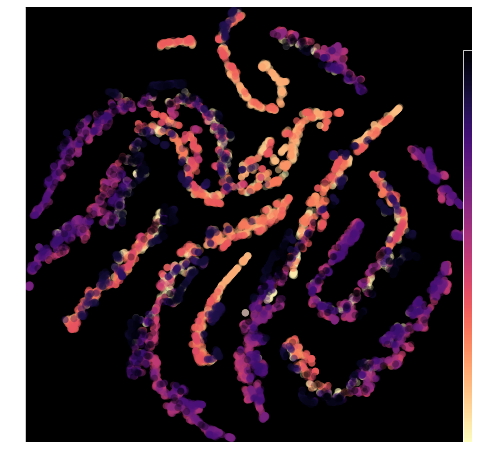

In [29]:
ax = plot_settings.get_double_square_axis()

colorbar_ticks = []

for i, org in enumerate(organs):
    idxs = np.where(np.asarray(organ_listing) == org)
    org_adata = anndata.AnnData(flattened_data[idxs])
    org_adata.obs['organ'] = np.asarray(organ_listing)[idxs]
    org_adata.obs['time'] = time_listing.astype(np.float64)[idxs]
    org_adata.obsm['X_tsne'] = tsne_data[idxs]

    velocity_plot_utils.velocity_embedding_stream(
        org_adata, V=flat_smoothed_avg_vels[idxs], 
        n_neighbors=100, cutoff_perc=1, color='time', 
        alpha=0.3, density=0.1, smooth=1.0,
        size=200, linewidth=0, arrowsize=0, ax=ax,
        arrow_color='whitesmoke', 
        color_map='magma_r', legend_loc='upper right')
    
plot_utils.format_ax(ax)
plt.savefig(fig_dir + 'figure_3b.pdf')

Fig. 3c

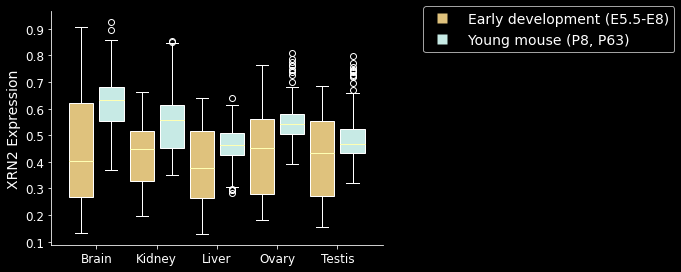

In [50]:
smoothed_res = {}
for org in organs:
    smoothed = []
    for n in range(N):
        smoothed.append(aging_utils.moving_average(data[org][n], k=4))
    smoothed_res[org] = np.stack(smoothed, axis=0)

statistical_time_range = 25
use_organs = ['Brain', 'Kidney', 'Liver', 'Ovary', 'Testis']

early_time_color = plot_settings.get_sag_vs_baseline_colors('baseline')
late_time_color = plot_settings.get_sag_vs_baseline_colors('Sagittarius')
g = 673  # XRN2 index

ax = plot_settings.get_wider_axis(double=True)
plot_utils.box_plot(ax, [data[org][:, :statistical_time_range, g].flatten() for org in use_organs],
                    positions=np.arange(1, len(use_organs)+1, 1), widths=0.4, xlabel='', ylabel='XRN2 Expression',
                    box_colors=[early_time_color for _ in use_organs])
plot_utils.box_plot(ax, [data[org][:, -statistical_time_range:, g].flatten() for org in use_organs],
                    positions=np.arange(1.5, len(use_organs)+1, 1), widths=0.4, xlabel='', ylabel='XRN2 Expression',
                    box_colors=[late_time_color for _ in use_organs], 
                    xticks=np.arange(1.25, len(use_organs)+1.25, 1), xticklabels=use_organs)
complete_col_list = [early_time_color, late_time_color]
complete_name_list = ['Early development (E5.5-E8)', 'Young mouse (P8, P63)']
lp = lambda i: plt.plot([],color=complete_col_list[i], ms=10, mec="none",
                        label=complete_name_list[i], ls="",  marker="s")[0]
handles = [lp(i) for i in range(2)]
plot_utils.format_legend(ax, handles, complete_name_list)
plot_utils.put_legend_outside_plot(ax)
plot_utils.format_ax(ax)
plt.tight_layout()
plt.savefig(fig_dir + 'figure_3c.pdf')

Fig. 3d

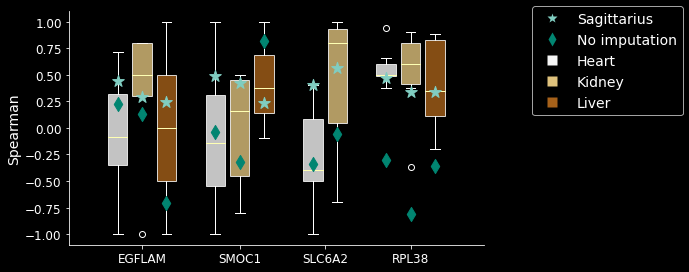

In [51]:
genes = ['EGFLAM', 'SMOC1', 'SLC6A2', 'RPL38']
tissues = {'Heart': 'Heart_and_Aorta', 'Kidney': 'Kidney', 'Liver': 'Liver'}
res_dir = 'results/EvoDevo/'

with open(res_dir + 'imputed_correlations.txt', 'r') as f:
    imputed_corrs = json.load(f)
    
with open(res_dir + 'evodevo_correlations.txt', 'r') as f:
    gt_corrs = json.load(f)
    
with open(res_dir + 'tabula_correlations.txt', 'r') as f:
    tm_corrs = json.load(f)
    

ax = plot_settings.get_wider_axis(double=True)
hex_cols = plot_settings.get_TM_color_palette()
baseline_col = hex_cols['baseline']
sag_col = hex_cols['Sagittarius']
colors = {tiss: hex_cols[tiss] for tiss in tissues.keys()}
tissue_list = [t for c in genes for t in sorted(tissues.keys()) if t in tm_corrs[c]]
full_colors = [hex_cols[tiss] for tiss in tissue_list]
full_positions = [
        gene_idx + 0.25 * t - (0.25 if gene_idx==3 else 0) for gene_idx, c in enumerate(genes) 
    for t in range(len(tm_corrs[c]))]

plot_utils.scatter_plot(
    ax, full_positions, [imputed_corrs[t][g] for g in genes for t in sorted(tissues) if t in tm_corrs[g]],
    '', 'Spearman', color=sag_col, alpha=1, size=150, style='*')
plot_utils.scatter_plot(
    ax, full_positions, [gt_corrs[t][g] for g in genes for t in sorted(tissues) if t in tm_corrs[g]],
    '', 'Spearman', color=baseline_col, alpha=1, size=100, style='d')

plot_utils.box_plot(
    ax, [list(tm_corrs[c][t].values()) for c in genes for t in sorted(tissues.keys()) if t in tm_corrs[c]],
    '', 'Spearman', xticks=[0.25, 1.25, 2.125, 3.0], xticklabels=genes, box_colors=full_colors,
    alpha=0.8, widths=0.2, positions=full_positions)

complete_col_list = [sag_col, baseline_col] + [colors[tiss] for tiss in sorted(list(tissues.keys()))]
complete_name_list = ['Sagittarius', 'No imputation'] + sorted(list(tissues.keys()))
markers = ['*', 'd', 's', 's', 's']
lp = lambda i: plt.plot([],color=complete_col_list[i], ms=10, mec="none",
                        label=complete_name_list[i], ls="",  marker=markers[i])[0]
handles = [lp(i) for i in range(5)]
plot_utils.format_legend(ax, handles, complete_name_list)
plot_utils.put_legend_outside_plot(ax)
plt.tight_layout()
plot_utils.format_ax(ax)
plt.savefig(fig_dir + 'figure_3d.pdf')